<a href="https://colab.research.google.com/github/IFuentesSR/Reservoir_area_Sentinel2/blob/main/Summer_School_2022_reservoirs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

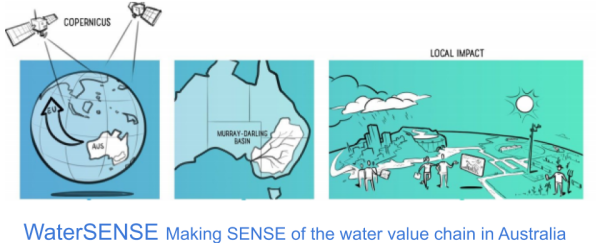

# <center>WaterSENSE (The University of Sydney - Water Technology)</center>

### <center>Reservoir stages, area/volume curves, and water volume estimations</center>


---



---


## Colab notebooks

<div style='text-align: justify'>Colab brings the same functionality as Jupyter notebooks, but it works on the cloud, using google servers, and allows a collaboratory instance for programing.
Since it works as a Jupyter notebook, and we want to use some basic libraries, we'll start importing os (to define paths to our files and folders), folium (to display maps), numpy (to work with arrays), pandas (to work with dataframes), matplotlib (to plot some results), and a function for 1D interpolation from scipy.
Let's also create a scatter plot to test that the colab is working.</div>

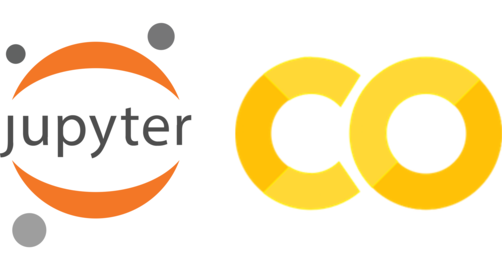
<!-- <img src="https://drive.google.com/uc?id=1Eqxgrs3JO6asLmYKmanGauy6LNlZ68pC" align=right> -->




In [ ]:
import os
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [ ]:
a = np.linspace(1, 100, 100) + np.random.normal(0, 5, 100)
b = np.linspace(1, 100, 100)
plt.scatter(a, b)

## Google Earth Engine integration



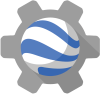
<!-- <img src="https://drive.google.com/uc?id=1KZdklRnYBBYeOsbYK8sTzAg0mO8Ak8AZ" align=right width="100"> -->

In [ ]:
# Import, authenticate and initialize the Earth Engine library.
# skip without GEE account
import ee
ee.Authenticate()
ee.Initialize()

We'll be working with three on-farm dams from the Namoi catchment. These reservoirs have the advantage of presenting a digital terrain model associated, which was obtained from LiDAR images. 

If you want to get LiDAR data you can use the [Elevation - Foundation Spatial Data (ELVIS)](https://elevation.fsdf.org.au/) webpage.

For the purpose of this tutorial, you can (if you want) select a polygon surrounding the Namoi river between Boggabri and Wee Waa in NSW. Then you should select all 1 m DEMs, and submit your request. A link will be sent to you to download a zip file containing the files.

Extract the files.

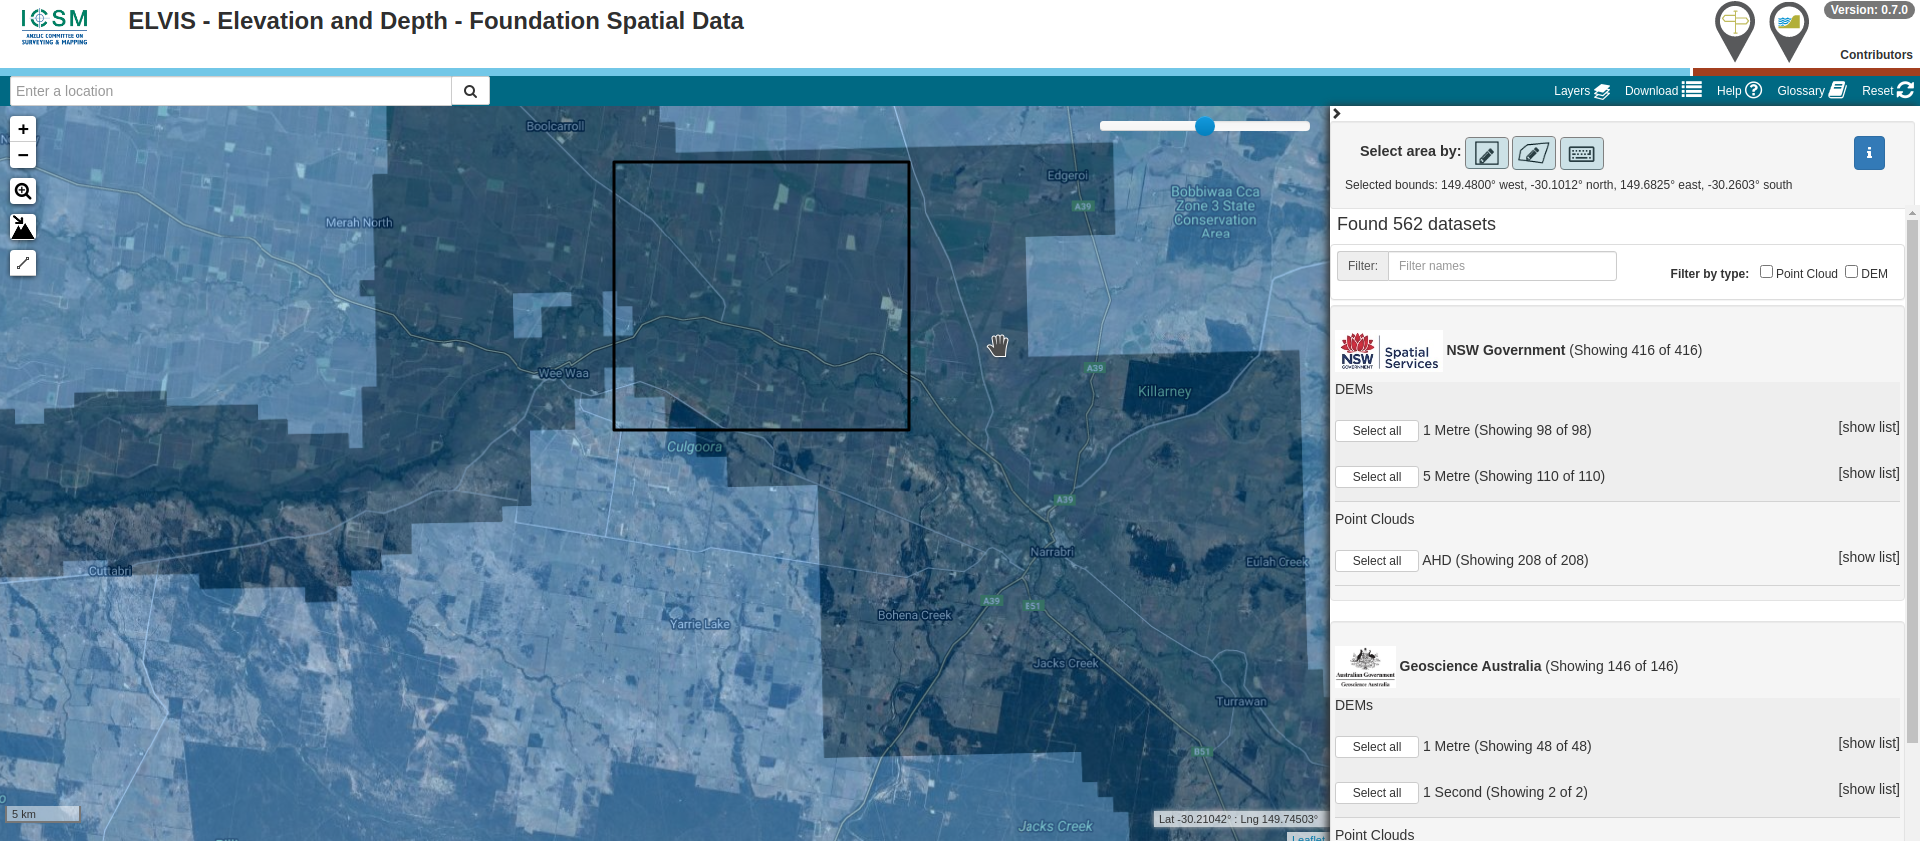


Yes, as you'll notice it's a bunch of zip files. So you'll have to unzip all of them and then merge all rasters. 

[Here](https://drive.google.com/file/d/1HSgEpDWEK4_JJL4JsLzGArVpEtb3NIcK/view?usp=sharing) is a script that I wrote that does all the work for you. You only have to pass the path as the argument for the script (in your terminal run *python processing_dem.py "your_path_of_zip_files"*. It should create an *Extract* folder within the path, unzip all files and extract them in this folder, and also create a mosaic file stored in the same folder. However, you'll need gdal and rasterio. If you don't have them it'll retrieve an error and you should install them. 

Once you have your mosaic, you can upload it to GEE.

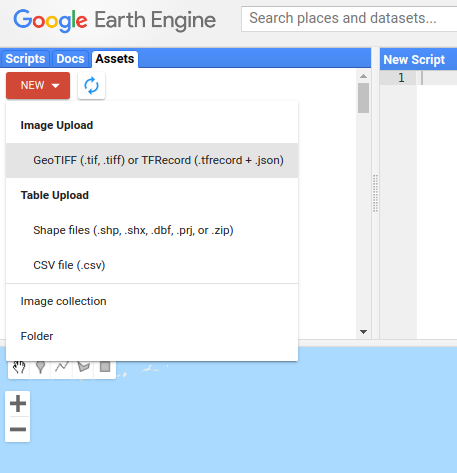

Subsequently, you'll have to import the LiDAR mosaic into this notebook to start working with it. 

I've shared a series of LiDAR rasters so everyone can access them.

Therefore, we'll start calling those objects. Since the LiDAR data covering the area contains two scenes, we'll resample these scenes and use the mosaic function to create a single DEM image. We resampled these scenes, and after applying the mosaic function, we use a convolution with a Gaussian kernel that smooths our image, trying to remove artifacts caused by the LiDAR detection and processing tasks. In this case, we'll use a 5-pixel kernel (radius), and a sigma of 3. You might try other values.  

In [ ]:
dams = ee.FeatureCollection("users/ignaciofuentessanroman/both_alternatives")
dem0 = ee.Image('users/ignaciofuentessanroman/AU/DEMNamoi2')
dem1 = ee.Image('users/ignaciofuentessanroman/AU/DEMNarrabri')

dem = ee.ImageCollection([dem0.updateMask(dem0.gt(0)).resample('bicubic'),
                          dem1.updateMask(dem1.gt(0)).resample('bicubic')
                          ]).mosaic().convolve(ee.Kernel.gaussian(5, 3))

Let's inspect our dams!
We'll select the first feature in the shapefile (FeatureCollection in GEE) using the **first** function. Then we'll apply the **propertyNames** function, which returns the list of attributes of our feature. However, if we print this, you'll notice that it retrieves a GEE object. Therefore, we pass the **getInfo** function which decodes our GEE object into a python list.

In [ ]:
dams.first().propertyNames().getInfo()


The name of the dams is stored in the *U_Final_ID* field. If we want to inspect the names, we can use the **aggregate_array** function, passing the field as the main argument of the function. This will print the list of names of our reservoirs.

In [ ]:
dam_names = dams.aggregate_array('U_Final_ID').getInfo()
dam_names

OK, let's visualise the data that we are working with. 
First, we need to define a centroid for visualisation. 

To do this, we need to get the geometry of our shapefile. We can do this using the **geometry** function for FeatureCollections(shapefiles), and geometries have several properties, such as **centroid**, which returns the centroid of the shapefile as a dictionary containing coordinates. 

In [ ]:
centroid = dams.geometry().centroid().getInfo()
centroid

## Mapping DEM and dams
In order to create maps to display our objects, we'll use Folium.
* Firstly, we define a map, passing the location which centers the map based on a point of latitude and longitudes, and setting a zoom level.
* Then we define the objects to be mapped with visualisation properties using the **getMapId** function. 
* Later, we pass those objects as TileLayers which are added to the map.  

You can inspect the map, zoom in, move it, display some of the layers used.

In [ ]:
map = folium.Map(location=[centroid['coordinates'][1],
                           centroid['coordinates'][0]],
                 zoom_start=11)
dam_polys = ee.FeatureCollection(dams).getMapId()
map_dem = dem.getMapId({'min':150, 'max':300})
folium.TileLayer(
    tiles=map_dem['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='dem',
  ).add_to(map)
folium.TileLayer(
    tiles=dam_polys['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='dams',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

### Working with a single dam.
________________________________ 
We'll filter our dams shapefile (Feature Collection) based on the first element in the list of dam_names that we created above. Filters always return a FeatureCollection, even if they contain one element. Therefore, we need to use the **first** function to get a single element as a Feature. 


In [ ]:
single_dam = dams.filter(ee.Filter.eq('U_Final_ID', dam_names[0])).first()

Let's map the dam and the DEM

In [ ]:
new_centroid = single_dam.geometry().centroid().getInfo()
map = folium.Map(location=[new_centroid['coordinates'][1],
                           new_centroid['coordinates'][0]],
                 zoom_start=15)
dam_poly = ee.FeatureCollection(dams).getMapId()
map_dem = dem.getMapId({'min':100, 'max':300})
folium.TileLayer(
    tiles=map_dem['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='dem',
  ).add_to(map)
folium.TileLayer(
    tiles=dam_poly['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='dam',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

### Criteria definition



---



---


In terms of dam building, in NSW, there are engineering standard guidelines for dam construction. In this case, for instance, the decision regarding the free water board is defined to avoid structural damage associated with waves impacting the crest of the dams.

Therefore, we have to do our analysis and calculations considering this information. Let's estimate some elevation parameters in the dam (max and min elevation, topwater elevation), and let's set a list of elevations in our dam.

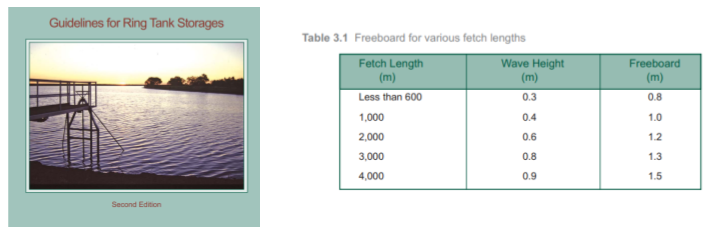

Therefore, we'll search for the maximum elevation (Crest), define a freeboard, and then calculate the topwater elevation in the dam. 

To calculate maximum or minimum elevations we need to use **reduceRegion**, which allows getting some statistics for specific regions. In this case, we pass the type of statistics required ('minMax'), the region (single_dam), and the scale (1 m). This returns a dictionary, from which we require the values. Then we **sort** those values to get a list of minimum and maximum elevations. 

We select a free board of 0.8 m, and calculate the topwater elevation.

Additionally, we'll create a set of elevations from the minimum elevation, up to the topwater elevation, by 0.2 m steps, using the function **ee.List.sequence()**. We remove the first elevation, since it won't allow us to create a polygon for calculations, and we know that the inundated area and volume at the minimum depth is 0.

In [ ]:
elev_boundaries = dem.reduceRegion('minMax', single_dam.geometry(), 1).values().getInfo()
elev_boundaries = np.sort(elev_boundaries)
min_elev, max_elev = elev_boundaries[0], elev_boundaries[1]
free_board = 0.8
top_water = max_elev - free_board
step = 0.2
levels = ee.List.sequence(min_elev, top_water, step).add(top_water).slice(1)

Now, let's select a single level (the top water level) to calculate are and volumes. Since levels is a *ee.List* object, we get elements through the **get** function, passing the index as argument. 

Then with that level, we clip the DEM to the extent of our single_dam polygon, and create a mask getting all pixels that are below the level chosen using the **lt** function (for lower than).

Since this creates a mask (binary raster with 0 and 1), we can multiply the raster with the level chosen to get a water level raster. We force this raster to contain float numbers (**toFloat** function) and remove those pixels above the level (equal to 0) passing the **selfMask** function. 



In [ ]:
l = levels.get(-1)#Info()
raster_l = dem.clip(single_dam).lt(ee.Image.constant(l))
raster_l = raster_l.multiply(ee.Image.constant(l)).toFloat().selfMask() # to force it to be floats (It'll depend on your topWater)

### Let's map the water level raster (raster_l)

In [ ]:
map = folium.Map(location=[new_centroid['coordinates'][1],
                           new_centroid['coordinates'][0]],
                 zoom_start=17)
lev_id = raster_l.getMapId({min:0, max:l.getInfo()})
folium.TileLayer(
    tiles=lev_id['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='max_mask',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

We'll need also a polygon of the water level raster.
Therefore, we'll vectorise it using **ReduceToVectors**, yet it requires a two-band raster, with the first band containing integers. Thus, first we create a mask of the water level, and append the water level raster as a band.

Then we vectorise the raster passing a statistic (first in this case), a region, and the scale of our vectorisation. The result of the vectorisation is a Feature Collection, even if it contains a single Feature. Therefore, to get the single feature, the function **first** needs to be used.

In [ ]:
peri = raster_l.gt(0).addBands(raster_l) # first band must be integral
peri = peri.reduceToVectors('first', single_dam.geometry(), 0.5)

Let's map the polygon of the water level raster.

In [ ]:
map = folium.Map(location=[new_centroid['coordinates'][1],
                           new_centroid['coordinates'][0]],
                 zoom_start=17)
dam_polys = ee.FeatureCollection(peri).getMapId()
folium.TileLayer(
    tiles=dam_polys['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='max_mask',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

Now, we can simply calculate the area through the **area** function for vectors.
If we want to estimate the volumes, we need to create a water depth raster, by subtracting the DEM elevation to the water level raster.

Then, this needs to be multiplied by the area (ee.Image.pixelArea()), and the resulting pixels need to be summed to get the volume (volume = area x depth) through the **reduceRegion** function.

In [ ]:
area_l = ee.Feature(peri.first()).area(1)
depth_l = raster_l.subtract(dem)
volume_l = depth_l.multiply(ee.Image.pixelArea()).reduceRegion('sum', ee.Feature(peri.first()).geometry(), 1).values().get(0)

Let's map the water depth raster

In [ ]:
map = folium.Map(location=[new_centroid['coordinates'][1],
                           new_centroid['coordinates'][0]],
                 zoom_start=17)
depth = ee.Image(depth_l).getMapId({'min':0, 'max':6, 'palette':'FF0000, 00FF00, 0000FF'})
folium.TileLayer(
    tiles=depth['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='depth',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

and let's print the inundated area and volume for the specified water level:

In [ ]:
print('area = {} m²; volume = {} m³'.format(area_l.getInfo(), volume_l.getInfo()))

## Creating a function from all previous code
If we want to run this in an iteration to get all volumes and areas for all water levels in the reservoirs we can stack all the chunks of code in a single function, which will return a feature for each level, containing the level, area and volume.

In [ ]:
def get_area_volume(dam):
    def wrap(level):
        raster_level = dem.clip(dam).lt(ee.Image.constant(level))
        raster_level = raster_level.multiply(ee.Image.constant(level)).toFloat().selfMask()
        peri = raster_level.gt(0).addBands(raster_level)
        peri = peri.reduceToVectors('first', dam.geometry(), 0.5)
        area_level = ee.Feature(peri.first()).area(1)
        depth_level = raster_level.subtract(dem)
        volume_level = depth_level.multiply(ee.Image.pixelArea()).reduceRegion('sum', ee.Feature(peri.first()).geometry(), 1).values().get(0)
        return ee.Feature(peri.first().geometry(), {'level':level, 'area':area_level, 'volume':volume_level})
    return wrap

Let's run this function for all levels in the dam and store it as a dictionary

In [ ]:
volume_areas = levels.map(get_area_volume(single_dam))
curve = volume_areas.getInfo()

Let's retrieve lists of levels, areas, and volumes which are stored as properties using list comprehensions: 

In [ ]:
levels1 = [n['properties']['level'] for n in curve]
areas = [n['properties']['area'] for n in curve]
volumes = [n['properties']['volume'] for n in curve]

and let's plot the area/volume curve for our reservoir:

In [ ]:
plt.plot(areas, volumes)
plt.xlabel ('area (m²)', fontsize=14)
plt.ylabel ('volume (m²)', fontsize=14)
plt.title(dam_names[0])
plt.show()

Now, imagine what can we do with this. Basically, if we use an interpolator, we could convert any inundated area into volumes. Let's try it:

In [ ]:
interpolator = interp1d(areas, volumes, bounds_error=False)
interpolator(255555)

## Comparison against governmental area/volume curves


We have stored the area/volume curves of these three reservoirs delivered by the government. These are stored in a shared Google Drive folder named summer2022.

To obtain access to the datasets used in this work you need to follow the following steps:
* Click on [this](https://drive.google.com/drive/u/0/folders/1VKeBs8xSGw1bs-C2RFAxmk9r5bqetpLF) Google Drive folder link. 

* Then, right click on the **Summer2022** folder and select **Add shortcut to Drive**.

![picture](https://drive.google.com/uc?id=11wpfOiNFcYwMuUdg07C4Tx-ZfVLDu3a-)

* Make a shortcut of the **Summer2022** folder in your own **My Drive**-folder, by clicking on **Add shortcut**. 

![picture](https://drive.google.com/uc?id=1-LANh1A0Gq6G5v5KxiYuIoA4EF2YeNet)

A new Google Drive folder with all the contents of this study has been linked to your Google Drive; therefore, we can link our Google Drive account to have access to the data. Then, we will need to connect to our Google Drive.

## Connecting to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Let's store the name of our single dam as a name variable

In [ ]:
name = single_dam.get('U_Final_ID').getInfo()

and let's define the path to our summer2022 folder to get access to the government data.

In [ ]:
path = 'drive/My Drive/summer2022'

Now, let's find the government area/volume curve for the same dam and let's read the csv file containing that information.

In [ ]:
file = [n for n in os.listdir(path) if name in n]
df = pd.read_csv(os.path.join(path, file[0]), skiprows=[1])
df

Let's plot both curves, the one obtained using the LiDAR data, and the one from the government

In [ ]:
plt.plot(df['Area'], df['Volume'], label='government')
plt.plot([n/10000 for n in areas], [n/1000 for n in volumes], label='LiDAR')
plt.legend()
plt.xlabel ('area (ha)', fontsize=14)
plt.ylabel ('volume (ML)', fontsize=14)
plt.show()

And finally, let's calculate some performance metrics using our interpolator

In [ ]:
df.loc[:, 'pred'] = interpolator(df['Area']*10000)
df = df.dropna(how='any')
rmse = np.mean((df['pred']/1000 - df['Volume'])**2)**0.5
print('RMSE = {}'.format(round(rmse, 2)))

# Combining Sentinel 2 data

One of the cool things about this is that you could basically get inundated areas for your reservoir and use these to calculate stored volumes. This can be done using satellite data.

In this example, we'll use the Fisher et al. (2015) algorithm that was developed for Australia:

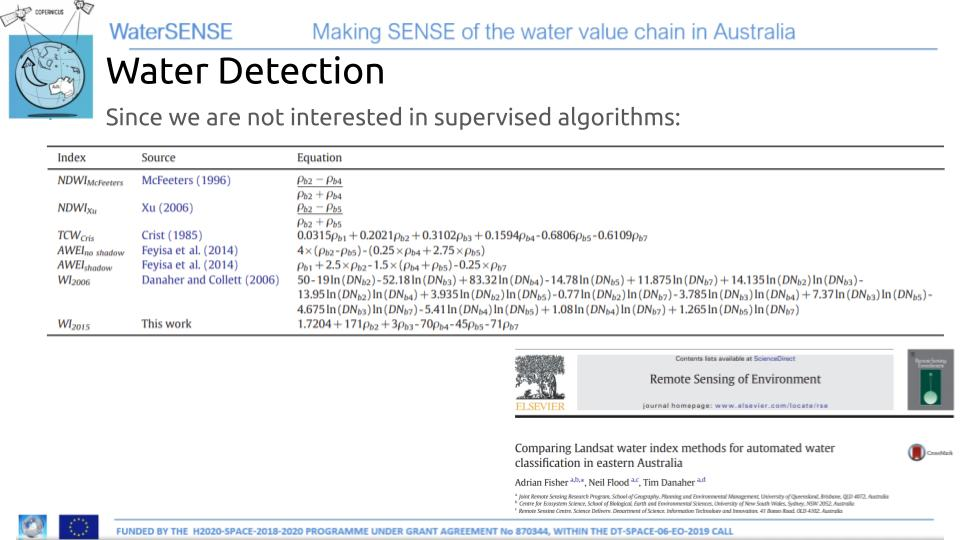
<!-- <img src='https://drive.google.com/uc?id=1ud_D1VaKmXdWO7z3H_KcYYk8On3x_Usd' width=800>  -->

So, let's set some functions:
* First, Fisher et al. (2015) water index uses one image (img) as an argument. It divides surface reflectance bands by 10000 to scale them, copies the properties of each image, and retrieves an image of the water index.
* Second, we assume a threshold of 0 to create water masks, and return these masks.


In [ ]:
def fisher_wi(img):
    img = ee.Image(img).divide(10000)
    props = img.propertyNames()
    return img.expression('1.7204 + 171 * Green + 3 * Red - 70 * NIR - 45 * SWIR1 - 71 * SWIR2',
                          {'Green':img.select('B3'),'Red':img.select('B4'), 
                           'NIR':img.select('B8'),'SWIR1':img.select('B11'),
                           'SWIR2':img.select('B12')}).rename('WI').copyProperties(img, props)
                           

def water_mask(img):
    img = ee.Image(img)
    props = img.propertyNames()
    return img.gt(0).copyProperties(img, props)

Let's load the Sentinel 2 surface reflectance collection, filter it based on our dam (single_dam), and filter it to get only images with less than 20% of clouds.

Then, let's get a single image filtering by date, and apply our functions.  

In [ ]:
S2 = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(single_dam.geometry()).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
img = S2.filterDate('2022-01-01', '2022-03-01').first()
water_ix = fisher_wi(img)
mask = water_mask(water_ix)

## Mapping the S2 image and its associated rasters

In [ ]:
map = folium.Map(location=[new_centroid['coordinates'][1],
                           new_centroid['coordinates'][0]],
                 zoom_start=17)
example = ee.Image(img).getMapId({'bands':['B8', 'B4', 'B3'], 'min':0, 'max':3000})
wi = ee.Image(water_ix).getMapId({'min':-20, 'max':20})
mask_id = ee.Image(mask).getMapId()
folium.TileLayer(
    tiles=example['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='S2',
  ).add_to(map)
folium.TileLayer(
    tiles=wi['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='water_index',
  ).add_to(map)
folium.TileLayer(
    tiles=mask_id['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='water_mask',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

The Image is free of clouds in our reservoir. However, that's not always the case. Cloud and shadow masking from Sentinel 2 images is not as good as in Landsat. The surface reflectance product contains an **'SCL'**  band which is a classification used to remove clouds, shadows, among others. Yet, it's not like the Fmask from Landsat. Other approaches involve the use of some algorithms, and the projection of shadows based on the azimuth solar angle.
Please refer to the [following link](https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless) if you are after a relatively good cloud mask.

Finally, let's calculate the inundated area and the interpolated stored volume:

In [ ]:
area_test = ee.Image(mask).multiply(ee.Image.pixelArea()).reduceRegion('sum',
                                                                       single_dam.geometry(),
                                                                       10).values().get(0).getInfo()
print('area = {} m²; volume = {} m³'.format(np.round(area_test, 2),
                                            np.round(interpolator(area_test), 2)))

Do you want to test the other dams? 

Try to replicate the same workflow by just changing the dam selected.